In this notebook, we take previously computed climate-optimized trajectories and resolve conflicts in the schedule. One conflict that needs to be resolved is the case when more than 4 planes are in the same voxel at the same time. In this case, we model the decision to resolve this conflict by changing the trajectory by +- 20 FL with a binary decision variable. We can use this formulation in a QUBO problem where the cost function is the climate cost and the penalties are additional constraints. In this way, we can use F-VQE to find the optimal conflict solution.

# Import Libraries

In [1]:
import sys
sys.path.append("/home/felix/PycharmProjects/Quantum-Challenge/")
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import traceback
import math
import networkx as nx
import itertools
from qiskit.algorithms import AmplificationProblem
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover
from qiskit.circuit.library import GroverOperator
from qiskit.extensions import Initialize
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from itertools import product 
from qiskit.quantum_info import Statevector
from importlib import reload
import utils.utils as ut
from pytket.circuit import Circuit
from pytket.extensions.qiskit import AerStateBackend, AerBackend  
from pytket.circuit.display import render_circuit_jupyter
from pytket.utils.results import probs_from_state  
from qiskit.quantum_info import partial_trace, entropy, Statevector  
import copy

# Load flight Data 

In [2]:
flight_df = pd.read_csv("../data/flights.csv", sep=";")

# Load velocity and fuel consumption data

In [3]:
cruise_df = pd.read_pickle("../data/cruise_df.pkl")
climb_df = pd.read_pickle("../data/climb_df.pkl")
descent_df = pd.read_pickle("../data/descent_df.pkl")

# Load climate data

In [4]:
climate_df = pd.read_pickle("../data/climate_df.pkl")

# Load Climate Optimized Flight Schedule

In [5]:
q_traj_arr = np.load("../data/c_climate_trajectory_arr.npy", allow_pickle=True)

# De-Conflicting

The flight plan imported above is a list of aircraft with a number of overlaps that need to be modified to ensure a safe flight protocol. We consider an overlap as an important event when there are more than 4 aircraft in the same voxel in an overlapping time frame. 


To solve this problem using VQEs, the disentanglement model is formulated as QUBO, where the cost is considered as the climate cost and the penalty is considered as the introduction of new conflicts. The decision variable of each bit is then whether the conflicting flight is diverted by $\pm 20$ FL.  




In [6]:
c, overlap_dict = ut.constraint_n_planes(q_traj_arr)

$c=2303$ is the number of total conflicts in the flight plan that need to be resolved. In our current problem formulation without further simplifications such as causal cones, we would need $2303$ qubits to resolve all conflicts at once. In the following, we select 5 random conflicts to perform this on a 5-qubit simulator.

The overlap_dict gives us the information we need to resolve the given conflicts. For example, at point 7, flight 0 has a total of 6 conflicts with the 1st, 28th, 45th, 62nd, 70th, and 80th flight.

In [7]:
overlap_dict[(0,7)]

[array([-20.0, 60.0, 340, numpy.datetime64('2018-06-23T08:42:45'),
        numpy.timedelta64(732,'s'), 1, 7], dtype=object),
 array([-20.0, 60.0, 340, numpy.datetime64('2018-06-23T08:44:28'),
        numpy.timedelta64(732,'s'), 28, 9], dtype=object),
 array([-20.0, 60.0, 340, numpy.datetime64('2018-06-23T08:59:44'),
        numpy.timedelta64(732,'s'), 45, 9], dtype=object),
 array([-20.0, 60.0, 340, numpy.datetime64('2018-06-23T08:37:55'),
        numpy.timedelta64(956,'s'), 62, 7], dtype=object),
 array([-20.0, 60.0, 340, numpy.datetime64('2018-06-23T08:32:45'),
        numpy.timedelta64(732,'s'), 70, 7], dtype=object),
 array([-20.0, 60.0, 340, numpy.datetime64('2018-06-23T09:02:55'),
        numpy.timedelta64(956,'s'), 80, 7], dtype=object)]

In [24]:
confl_list = np.array(list(overlap_dict.keys()))
choice_inx = np.random.choice(np.arange(len(confl_list)),size=5)
confl_arr = confl_list[choice_inx]
confl_arr

array([[ 5, 15],
       [30, 37],
       [ 6, 11],
       [17, 34],
       [25, 28]])

The confl_arr contains information about the conflicted flight path and at which point in the flight path this conflict occurs. For example, the 22nd flight in the flight plan has a conflict at its 24th transit point.

In [10]:
flight_df["cost"] = [ut.C(traj) for traj in q_traj_arr]

In [75]:
unique_coord_dict = unique_coord(q_traj_arr)
confl_list = get_confl_arr(unique_coord_dict)
choice_inx = np.random.choice(np.arange(len(confl_list)),size=5)
confl_arr = confl_list[choice_inx]

# Quantum Circuit

To solve the de-conflicting problem, I implement a simplified version of the filtering variational quantum eigensolver.https://arxiv.org/pdf/2106.10055.pdf 
I was interested in learning more about this algorithm and took this as an opportunity to deepen my understanding of its application to a combinatorial optimization problem. The main idea here is that applying a filtering operator $f=H^{-\tau}$ to a quantum state $|\Psi>$ shifts its probability distribution of eigenvectors in such a way that low energy states dominate. This idea borrows from imaginary time evolution. 

In general, any arbitrary wavefunction can be written as a superposition of eigenstates:


$$\psi(x,0) = \sum_i a_i(0) \psi_i(x) $$
and
$$ \psi(x,t) = \sum_i exp(-it E_n / \hbar ) a_i(0) \psi_i(x) $$


Eigenstate don't change in their overall magnitude with increasing time evolution but rotate with a frequency proportional to the corresponding energy eigenvalue $En/\hbar$.




With the substitution $(it \rightarrow{} \tau )$ 


$$ \psi(x,\tau) = \sum_i exp(- \tau E_n / \hbar ) a_i(0) \psi_i(x) $$

we now see that $\psi(x,t)$ at imaginary time no longer consists of an "oscillating" superposition of energy eigenstates, but of an "exponentially decaying" superposition of energy eigenstates. Hereby, the higher energy states are decaying faster, so that with time the state with the lowest energy dominates the wave function.

The F-VQE algorithm can then be summarized as follows:
- Prepare an initial state $|\psi_0>$ that has finite overlap with the ground state $P(\lambda_0) > 0$.
- Iteratively, the application of the filter operator $F_t$ to $|\psi_{t-1}>$ is approximated by a state $|\psi_t>$. 
For this purpose, a parameterized quantum circuit ansatz $|\psi(\theta)>$ is used, which depends on a vector of m parameters
$\theta = (\theta_1, . . . , \theta_m)$. 
At each optimization step t, the parameters that minimize the Euclidean distance between the parameterized quantum state and $|F_t \psi_{t-1}>$ are sought. For this purpose, a gradient-based approach is chosen, where 

$$\theta_t \propto \theta_{t-1}-\sum_i \frac{\partial C_t(\theta)}{\partial \theta_i} \propto \theta_{t-1}-\sum_i <\psi_{t-1}|F_t|\psi(\theta \pm \frac{\pi}{2})>$$
Simply put, we rotate the parameter values by $\pm \frac{\pi}{2}$, calculate each result, and choose which rotation works best.
- Repeat for a given number of optimization steps.

In this case study we use a simplified version of the hardware efficient ansatz using $R_y$ and $Cnot$ gates repeated in several layers.

In [11]:
def ansatz(params):
    c = Circuit(n_qubits,0)
    params = params / np.pi  # pytket works in units of pi: Ry(p, q) = exp(-i pi p/2 Y_q)    c = Circuit(n_qubits)
    param_index = 0
    for q in range(n_qubits):
        c.Ry(params[param_index], q)
        param_index += 1
    for l in range(n_layers):
        for q in range(n_qubits-1):
            c.CX(q, q+1)
        for q in range(n_qubits):
            c.Ry(params[param_index], q)
            param_index += 1
    return c

n_qubits = 5
n_layers = 3  # number of ansatz circuit layers
n_params = n_qubits * (1 + n_layers)  

In [12]:
render_circuit_jupyter(ansatz(np.ones(n_params) * np.pi))

# Defining F-VQE prerequisites

This section defines the auxiliary functions of the F-VQE "protocol". I have tried to arrange them in descending order of importance.
As mentioned earlier, an important component of the F-VQE is the filtering operator $f$. It is defined as a real function $f(c)$, with $c$ as a real parameter, where $f^2(c)$ is strictly decreasing. Furthermore, the $\tau>0$ function parameter can be varied at each optimization step.
Here, an inverse filter was chosen because it showed the best performance in the F-VQE study.

In [13]:
# Filter: function f: c real to f(c) real such that f^2(c) strictly decreases

t = 1  # t>0 is a function parameter. Could be changed at each optimization step

def f(c, t):
    if c==0:
        return (c+e-10) ** (-t)    
    return c ** (-t)

The $\tau$ parameter is continuously adjusted to keep the gradient norm as close as possible to a desired large and fixed value to prevent the gradient from disappearing. 
 
In this case, the implementation is done using a simple heuristic diretly taken from the F-VQE paper.
At each iteration step, we want to choose $\tau$ such that the gradient norm is as close as possible but below a certain threshold $r$, i.e., we solve the implicit equation $\text{gradient_norm}(\tau) = r$


For this we evaluate the gradient norm for increasing values
of $\tau$ until an upper bound is found such that $\text{gradient_norm}(t_{up}) >= r$.
Then we search for $\tau$ in the range $[0, \tau_{up}]$ up to
a certain precision. 

Gradient where probs_plus/minus represents theta shifted by $\pm \frac{\pi}{2}$.
The partial derivative of a parameter is the difference 
between two circuits that differ in a positive/negative $\frac{\pi}{2}$
shift of the parameter. 

In [40]:
# Gradient evaluated at params

def g(params, t, spectrum, un_coord_dict):
    output = np.zeros(n_params)
    for i in range(n_params):
        params_plus = params + np.bincount([i], None, n_params) * np.pi / 2
        params_minus = params - np.bincount([i], None, n_params) * np.pi / 2
        probs_plus = sample_ansatz(params_plus)
        probs_minus = sample_ansatz(params_minus)
        filter_exp_plus, spectrum = evaluate(probs_plus, t, spectrum, un_coord_dict)
        filter_exp_minus, spectrum = evaluate(probs_minus, t, spectrum, un_coord_dict)
        output[i] = filter_exp_minus - filter_exp_plus
    return output, spectrum

In [15]:
# Sample ansatz circuit with tKet

# number of measurement shots. Each shot is one sample of the bitstring distribution produced by the quantum ansatz
n_shots = 5
backend = AerBackend()

def sample_ansatz(params):
    c = ansatz(params)
    c.measure_all()
    backend.compile_circuit(c)
    handle = backend.process_circuit(c, n_shots=n_shots)
    result = backend.get_result(handle)
    counts = result.get_counts()
    probs = {bitstring: c / n_shots for bitstring, c in counts.items()}  # samples from the bitstring distribution
    return probs

In [17]:
original_cost = np.sum([ut.C(tr)for tr in q_traj_arr])

In [19]:
traj_a = q_traj_arr
df = flight_df
def vqe_cost(bit_string, confl_arr, un_coord_dict):
    """ Get cost for vqe """
    traj_arr = traj_a[:]
    p = 0.1
    de_conflicted_traj_arr = ut.bitstr_to_traj(bit_string, confl_arr, traj_arr)
    improved_cost = ut.get_new_cost(confl_arr, de_conflicted_traj_arr, df)
    penalty = p*penalty_cnt(bit_string, confl_arr, traj_arr, un_coord_dict)

    return 100*(improved_cost - original_cost)/original_cost + penalty / 5e7

In [74]:
def unique_coord(trajec_arr):
    tr_arr = copy.deepcopy(trajec_arr)
    for cnt_1, tr in enumerate(tr_arr):
        for cnt_2, point in enumerate(tr):
            point["tr_inx"] = cnt_1
            point["pn_inx"] = cnt_2

    flat_traj = []
    for cnt_1, sublist in enumerate(tr_arr):
        for cnt_2, item in enumerate(sublist):
            temp_list = list(item.values())
            flat_traj.append(temp_list)  # trajec index and point in trajec index
    flat_traj = np.array(flat_traj, dtype=object)

    unique_coord, index, count = np.unique(np.array(flat_traj[:, 0:3], dtype=float), axis=0, return_index=True, return_counts=True)
    
    unique_coord_dict = {}
    for x,y,z in unique_coord:
        unique_coord_dict[str(int(x))+"_"+str(int(y))+"_"+str(int(z))] = []
        
    for point in flat_traj:
        x, y, z, t, delta_t, tr, pn = point
        unique_coord_dict[str(int(x))+"_"+str(int(y))+"_"+str(int(z))] += [[t, delta_t, tr, pn]]
    return unique_coord_dict

In [126]:
def get_confl_arr(un_coord_dict):
    confl_arr = []
    for k,v in un_coord_dict.items():
        cnt = 0   
        if len(v)>4:
            temp_confl = []
            cnt = 0 
            for inx in range(len(v)):
                 
                for inx_2 in range(inx,len(v)):
                    time_diff = np.abs(v[inx][0] - v[inx_2][0])
                    if v[inx][1] == 0 :
                        continue
                    if time_diff < v[inx][1]:
                        temp_confl += [[ v[inx][2],v[inx][3]]]
                        cnt += 1 
        if cnt > 3:
            confl_arr += temp_confl
    return np.unique(confl_arr, axis=0)

In [25]:
def count_confl(x,y,z, un_coord_dict):
    try:
        v = unique_coord_dict[str(int(x))+"_"+str(int(y))+"_"+str(int(z))]
    except:
        return 0 
    cnt = 0 
    for inx in range(len(v)):
        for inx_2 in range(inx,len(v)):
            time_diff = np.abs(v[inx][0] - v[inx_2][0])
            if time_diff < v[inx][1]:
                cnt += 1 
    return cnt    

In [152]:
# what happens when confl arr is not in v 
def comp_confl(x,y,z, un_coord_dict, confl_arr):
    try:
        v = np.array(unique_coord_dict[str(int(x))+"_"+str(int(y))+"_"+str(int(z))])
    except:
        return 0 
    
    found = False 
    for inx,i in enumerate(v):
        if i[2] == confl_arr[0] and i[3] == confl_arr[1]:
            found = True
            break
        
    if not found:
        return 0 
    v[[0, inx]] = v[[inx, 0]]
    

    cnt = 0 
    for inx in range(len(v)):
        time_diff = np.abs(v[0][0] - v[inx][0])
        if time_diff < v[0][1]:
            cnt += 1 
    if cnt > 3:
        return cnt
    else:
        return 0 
    

def penalty_cnt_bit(bit_string, confl_arr, traj_arr, un_coord_dict):
    p_cnt = 0 
    for bit, (tr_inx, pn_inx) in zip(bit_string, confl_arr):
        
        x = int(traj_arr[tr_inx][pn_inx]["x"])
        y = int(traj_arr[tr_inx][pn_inx]["y"])
        z_old = int(traj_arr[tr_inx][pn_inx]["z"])
        z_new = int(traj_arr[tr_inx][pn_inx]["z"]  -20 + bit * 40  )
        
        cnt_old = comp_confl(x,y,z_old, un_coord_dict, [tr_inx,pn_inx])
        cnt_new = comp_confl(x,y,z_new, un_coord_dict, [tr_inx,pn_inx])
        
        #if cnt_old<=cnt_new:
        p_cnt += cnt_new - cnt_old
    return p_cnt  
# comp_confl(14,60,380, unique_coord_dict, [36,25])
penalty_cnt_bit((0,0,0,0,0), confl_arr, q_traj_arr, unique_coord_dict)

-8

In [72]:
def penalty_cnt(bit_string, confl_arr, traj_arr, un_coord_dict):
    p_cnt = 0 
    for bit, (tr_inx, pn_inx) in zip(bit_string, confl_arr):
        
        x = int(traj_arr[tr_inx][pn_inx]["x"])
        y = int(traj_arr[tr_inx][pn_inx]["y"])
        z_old = int(traj_arr[tr_inx][pn_inx]["z"])
        z_new = int(traj_arr[tr_inx][pn_inx]["z"]  -20 + bit * 40  )
        
        cnt_old = count_confl(x,y,z_old, un_coord_dict)
        cnt_new = count_confl(x,y,z_new, un_coord_dict)
        #if cnt_old<=cnt_new:
        p_cnt += cnt_new - cnt_old
    return p_cnt  

-396

In [157]:
# change alt either until new alt change

def binary_to_traj(b_val, conflict_point, input_traj, un_coord_dict):
    """ Take binary value and translate it to changed trajectory array """
    traj = copy.deepcopy(input_traj)

    con_p_m1 = traj[conflict_point[0]][conflict_point[1] - 1]
    m_tup = ut.xyz_to_tuple(con_p_m1["x"], con_p_m1["y"], con_p_m1["z"])

    con_p = traj[conflict_point[0]][conflict_point[1]]
    con_p["z"] += (-20 + b_val * 40)
    change_tup = ut.xyz_to_tuple(con_p["x"], con_p["y"], con_p["z"])
    
    i = 1 
    continuous_confl = True
    while continuous_confl:
        x = traj[conflict_point[0]][conflict_point[1] + i]["x"]
        y = traj[conflict_point[0]][conflict_point[1] + i]["y"]
        z = traj[conflict_point[0]][conflict_point[1] + i]["z"]
    
       # print(x,y,z)
    #     print(comp_confl(x,y,z, un_coord_dict,[[conflict_point[0],conflict_point[1]+i]]))
        new_confl_cnt = penalty_cnt_bit((b_val,), [[conflict_point[0],conflict_point[1]+i]], input_traj, un_coord_dict)
        print(new_confl_cnt)
        if new_confl_cnt < 0:
            i+= 1
        else:
            continuous_confl = False
            break 
        
    
#     con_p_p1 = traj[conflict_point[0]][conflict_point[1] + 1]
#     p_tup = ut.xyz_to_tuple(con_p_p1["x"], con_p_p1["y"], con_p_p1["z"])

#     temp_path = ut.tuple_path_to_trajec([m_tup, change_tup], start_time=[con_p_m1["t"], con_p_m1["delta_t"]])
#     new_t = temp_path[1]["t"]
#     new_delta_t = temp_path[1]["delta_t"]

#     con_p["t"] = new_t
#     con_p["delta_t"] = new_delta_t

#     temp_path = ut.tuple_path_to_trajec([change_tup, p_tup], start_time=[con_p["t"], con_p["delta_t"]])
#     new_t = temp_path[1]["t"]
#     new_delta_t = temp_path[1]["delta_t"]

#     con_p_p1["t"] = new_t
#     con_p_p1["delta_t"] = new_delta_t

    #return traj
binary_to_traj(1, confl_arr[0], q_traj_arr, unique_coord_dict)

-4
-4
-4
-5
-5
-5
0


In [35]:
# Evaluate filter expectation value and build up the spectrum

spectrum = {}  # will contain a pair (bitstring, C(bitstring)) for each different sampled bitstring during experiment

def evaluate(probs, t, spectrum, un_coord_dict):
    filter_exp = 0
    for bitstring, p in probs.items():
        if bitstring not in spectrum:
            cost = vqe_cost(bitstring, confl_arr, un_coord_dict)
            spectrum[bitstring] = cost
        else:
            cost = spectrum[bitstring]
        filter_exp += f(cost, t) * p
    return filter_exp, spectrum

In [36]:
# Gradient-based optimiser

learning_rate = 0.01

def update_params(params, gradient):
    return params - learning_rate * gradient

In [56]:
# F-VQE algorithm
    
# initialises the quantum computer in the equal superposition

def fvqe(params, n_steps, un_coord_dict):
    spectrum = {}
    for step in range(n_steps):
        gradient, spectrum = g(params, t, spectrum, un_coord_dict)
        
        
        params = update_params(params, gradient)
      
        best_cost = min(spectrum.values())
        best_solutions = {bitstring for bitstring, cost in spectrum.items() if cost==best_cost}
#         print(f"step {step}: best cost = {best_cost} for {best_solutions}", "\n")
    return spectrum

In [57]:
params = np.array(list(np.zeros(n_params - n_qubits)) + list(np.ones(n_qubits) * np.pi / 2)) 
fvqe(params,  1, unique_coord_dict)

{(0, 0, 0, 1, 1): -0.001167915594906348,
 (0, 0, 1, 0, 1): -0.001167915594906348,
 (0, 1, 1, 0, 0): -0.000877757555220715,
 (1, 1, 0, 0, 1): -0.001167915594906348,
 (1, 1, 0, 1, 1): -0.001167915594906348,
 (0, 0, 1, 0, 0): -0.000877757555220715,
 (0, 1, 0, 1, 1): -0.001167915594906348,
 (1, 0, 0, 0, 1): -0.001167915594906348,
 (1, 1, 1, 0, 0): -0.000877757555220715,
 (0, 1, 1, 0, 1): -0.001167915594906348,
 (0, 1, 1, 1, 0): -0.000877757555220715,
 (1, 0, 0, 1, 1): -0.001167915594906348,
 (1, 1, 1, 0, 1): -0.001167915594906348,
 (1, 1, 1, 1, 0): -0.000877757555220715,
 (1, 0, 1, 0, 0): -0.000877757555220715,
 (1, 1, 0, 0, 0): -0.000877757555220715,
 (1, 1, 0, 1, 0): -0.000877757555220715,
 (0, 0, 0, 0, 0): -0.000877757555220715,
 (0, 0, 0, 0, 1): -0.001167915594906348,
 (0, 1, 0, 0, 0): -0.000877757555220715,
 (1, 0, 1, 1, 1): -0.001167915594906348,
 (0, 0, 0, 1, 0): -0.000877757555220715,
 (0, 0, 1, 1, 1): -0.001167915594906348,
 (0, 1, 1, 1, 1): -0.001167915594906348,
 (1, 1, 1, 1, 1)

In [ ]:
from qiskit import IBMQ
IBMQ.load_account("661471246b9d4562e2482696501b3334b2b2dc7f215ff96a3427581b1808dd04666ad023f0bd5c119028d979903872515e1d50fbe277a26aaaace1ac9961ac8f")

Take a state with minimal cost and compute the deconflicted flight schedule.

In [542]:
de_confl_tr = ut.bitstr_to_traj((0, 0, 1, 0, 1), confl_arr, q_traj_arr)

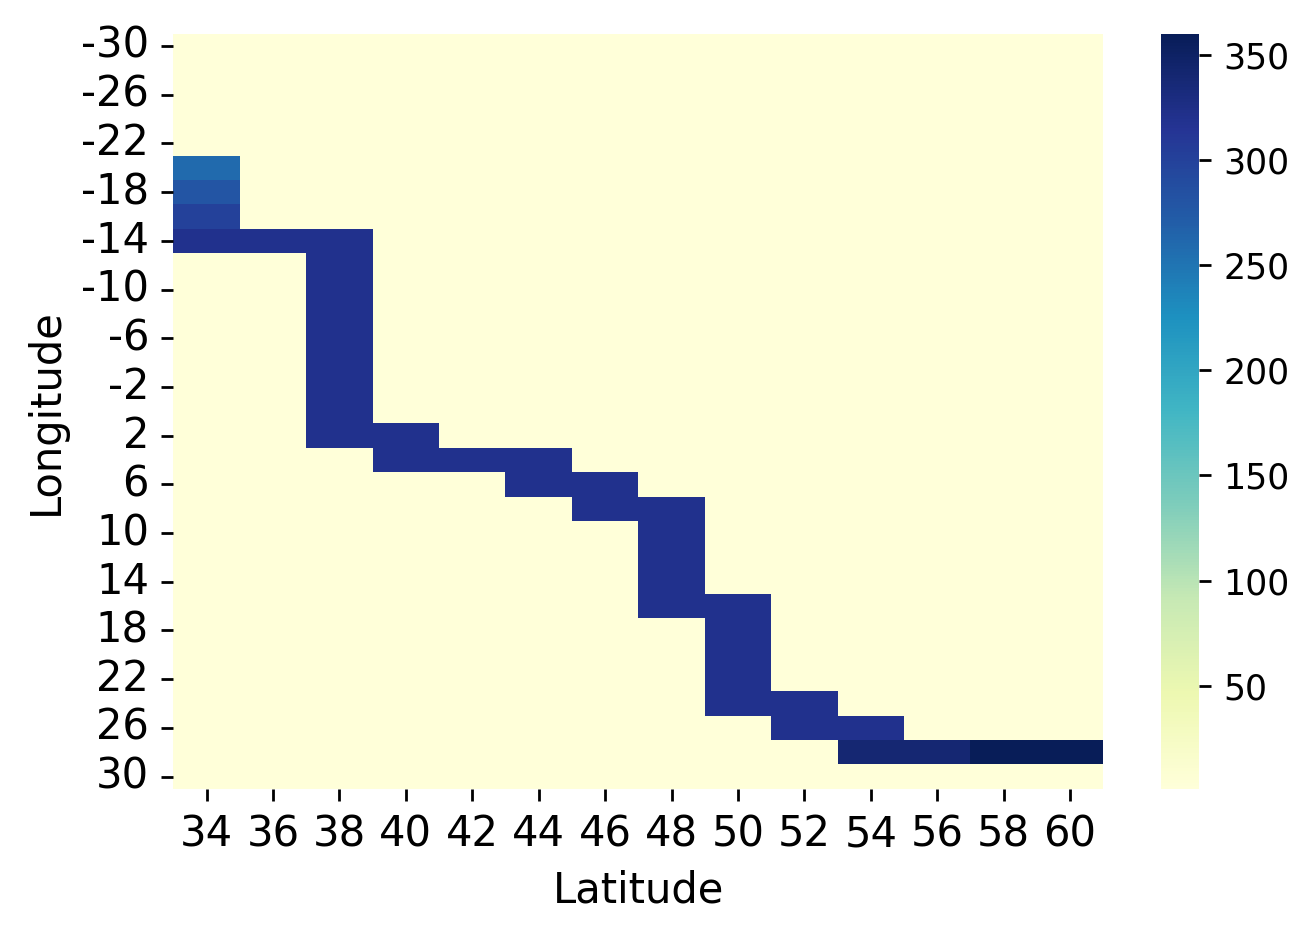

In [543]:
test_classical_traj = de_confl_tr[11]
box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))

for c_1, i in enumerate(x_arr):
    for c_2, j in enumerate(y_arr):
        box_2d[c_1][c_2] = 1
        for c_3, l in enumerate(test_classical_traj):
            if i == l["x"] and j == l["y"]:
                box_2d[c_1][c_2] = l["z"]#
                
fig, ax = plt.subplots(dpi=250) 
ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0, cmap="YlGnBu")
ax.set_ylabel("Longitude")
ax.set_xlabel("Latitude")

ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

ax.set_yticks(ax.get_yticks()[::2])
ax.legend
plt.show()

# Compute performance metric of flight schedule

In [514]:
np.sum([ut.C(tr)for tr in de_confl_tr])

5.0244316223676846e-06

In [515]:
np.sum([ut.consumed_fuel(tr)[0] for tr in de_confl_tr])

1854513.2230144157

In [516]:
np.sum([ut.time_traveled(tr)for tr in de_confl_tr])

numpy.timedelta64(2680147,'s')